In [2]:
!pip install datasets
!pip install tokenizers
!pip install transformers


     |████████████████████████████████| 325 kB 4.3 MB/s 
     |████████████████████████████████| 136 kB 49.1 MB/s 
     |████████████████████████████████| 1.1 MB 46.7 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 212 kB 47.1 MB/s 
     |████████████████████████████████| 127 kB 52.1 MB/s 
     |████████████████████████████████| 144 kB 47.9 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
     |████████████████████████████████| 271 kB 44.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 6.6 MB 4.4 MB/s 


In [3]:
from datasets import list_datasets, load_dataset 
from pprint import pprint
from tqdm.auto import tqdm
from pathlib import Path
from tokenizers import ByteLevelBPETokenizer
import os
from transformers import RobertaTokenizer
import torch
from transformers import RobertaTokenizer
from transformers import AdamW
from transformers import RobertaForMaskedLM
from transformers import RobertaConfig

In [4]:
det = list_datasets() 
#dataset attributes  
dataset = list_datasets(with_details=True)[det.index('medical_questions_pairs')] 
 
#calling the python dataclass 
pprint(dataset.__dict__)


{'author': None,
 'cardData': {'annotations_creators': ['expert-generated'],
              'language_creators': ['other'],
              'languages': ['en'],
              'licenses': ['unknown'],
              'multilinguality': ['monolingual'],
              'paperswithcode_id': None,
              'pretty_name': 'MedicalQuestionsPairs',
              'size_categories': ['1K<n<10K'],
              'source_datasets': ['original'],
              'task_categories': ['text-classification'],
              'task_ids': ['semantic-similarity-classification']},
 'citation': '@misc{mccreery2020effective,\n'
             '      title={Effective Transfer Learning for Identifying Similar '
             'Questions: Matching User Questions to COVID-19 FAQs},\n'
             '      author={Clara H. McCreery and Namit Katariya and Anitha '
             'Kannan and Manish Chablani and Xavier Amatriain},\n'
             '      year={2020},\n'
             '      eprint={2008.13546},\n'
             '  

In [5]:
med_dataset = load_dataset('medical_questions_pairs',split='train')
print(med_dataset)
print("Length of training set: ", len(med_dataset))

Using custom data configuration default


Generating train split:   0%|          | 0/3048 [00:00<?, ? examples/s]

Dataset medical_questions_pairs downloaded and prepared to /root/.cache/huggingface/datasets/medical_questions_pairs/default/0.0.0/db30a35b934dceb7abed5ef6b73a432bb59682d00e26f9a1acd960635333bc80. Subsequent calls will reuse this data.
Dataset({
    features: ['dr_id', 'question_1', 'question_2', 'label'],
    num_rows: 3048
})
Length of training set:  3048


In [6]:
print("First example from the dataset: \n") 
pprint(med_dataset[0])

First example from the dataset: 

{'dr_id': 1,
 'label': 1,
 'question_1': 'After how many hour from drinking an antibiotic can I drink '
               'alcohol?',
 'question_2': 'I have a party tonight and I took my last dose of Azithromycin '
               'this morning. Can I have a few drinks?'}


In [7]:
print("Features: ") 
pprint(med_dataset.features)
print("Column names: ", med_dataset.column_names)

Features: 
{'dr_id': Value(dtype='int32', id=None),
 'label': ClassLabel(num_classes=2, names=[0, 1], id=None),
 'question_1': Value(dtype='string', id=None),
 'question_2': Value(dtype='string', id=None)}
Column names:  ['dr_id', 'question_1', 'question_2', 'label']


In [8]:


text_data = []
file_count = 0

for sample in tqdm(med_dataset):
    tmp = sample['question_1'].replace('\n', '')
    sample = sample['question_2'].replace('\n', '')
    text_data.append(sample)
    # if len(text_data) == 10_000:
    #     # once we git the 10K mark, save to file
    #     with open(f'../../data/text/oscar_it/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
    #         fp.write('\n'.join(text_data))
    #     text_data = []
    #     file_count += 1
# after saving in 10K chunks, we will have ~2082 leftover samples, we save those now too
with open(f'../text_{file_count}.txt', 'w+', encoding='utf-8') as fp:
    fp.write('\n'.join(text_data))

  0%|          | 0/3048 [00:00<?, ?it/s]

In [9]:

paths = [str(x) for x in Path('../').glob('*.txt')]

In [10]:

tokenizer = ByteLevelBPETokenizer()
tokenizer.train(files=paths, vocab_size=20_000, min_frequency=2,
                special_tokens=['<s>', '<pad>', '</s>', '<unk>', '<mask>'])

In [11]:
os.mkdir('./medical')

tokenizer.save_model('medical')

['medical/vocab.json', 'medical/merges.txt']

In [12]:

tokenizer = RobertaTokenizer.from_pretrained('medical', max_len=512)
tokens = tokenizer('After how antibiotic can I drink alcohol?')
print(tokens)
tokens.input_ids

{'input_ids': [0, 2478, 603, 905, 339, 271, 1377, 1613, 35, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


[0, 2478, 603, 905, 339, 271, 1377, 1613, 35, 2]

In [13]:
with open('../text_0.txt', 'r', encoding='utf-8') as fp:
    lines = fp.read().split('\n')

batch = tokenizer(lines, max_length=512, padding='max_length', truncation=True)


In [14]:
print(len(batch['input_ids']))
for i in batch['input_ids']:
  print(i)
print(len(lines))

3048
[0, 45, 303, 261, 996, 93, 3260, 290, 271, 963, 310, 486, 1267, 306, 2792, 409, 1127, 18, 438, 271, 303, 261, 670, 1377, 87, 35, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
labels = torch.tensor([x for x in batch['input_ids']])
mask = torch.tensor([x for x in batch['attention_mask']])

In [16]:
# make copy of labels tensor, this will be input_ids
input_ids = labels.detach().clone()
# create random array of floats with equal dims to input_ids
rand = torch.rand(input_ids.shape)
# mask random 15% where token is not 0 [PAD], 1 [CLS], or 2 [SEP]
mask_arr = (rand < .15) * (input_ids != 0) * (input_ids != 1) * (input_ids != 2)
# loop through each row in input_ids tensor (cannot do in parallel)
for i in range(input_ids.shape[0]):
    # get indices of mask positions from mask array
    selection = torch.flatten(mask_arr[i].nonzero()).tolist()
    # mask input_ids
    input_ids[i, selection] = 3  # our custom [MASK] token == 3

In [17]:
input_ids.shape

torch.Size([3048, 512])

In [18]:
encodings = {'input_ids': input_ids, 'attention_mask': mask, 'labels': labels}

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        # store encodings internally
        self.encodings = encodings

    def __len__(self):
        # return the number of samples
        return self.encodings['input_ids'].shape[0]

    def __getitem__(self, i):
        # return dictionary of input_ids, attention_mask, and labels for index i
        return {key: tensor[i] for key, tensor in self.encodings.items()}
dataset = Dataset(encodings)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)


In [19]:


config = RobertaConfig(
    vocab_size=20_000,  # we align this to the tokenizer vocab_size
    max_position_embeddings=512,
    hidden_size=768,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1
)

In [20]:


model = RobertaForMaskedLM(config)

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# and move our model over to the selected device
model.to(device)

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(20000, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [22]:


# activate training mode
model.train()
# initialize optimizer
optim = AdamW(model.parameters(), lr=1e-4)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [38]:
epochs = 1

cor_loss =[]
batch_number=[]
i = 0

for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    loop = tqdm(loader, leave=True)

    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # process
        outputs = model(input_ids, attention_mask=attention_mask,
                        labels=labels)
        # extract loss
        loss = outputs.loss
        i += 1
        batch_number += [i]
        
        cor_loss += [loss.item()]

        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

  0%|          | 0/191 [00:00<?, ?it/s]

In [39]:
print(cor_loss)

[0.11429169774055481, 0.13474729657173157, 0.13232971727848053, 0.13814182579517365, 0.11399099230766296, 0.1299528032541275, 0.1324065923690796, 0.0934850201010704, 0.11959213018417358, 0.14009185135364532, 0.10111894458532333, 0.10872267931699753, 0.14187057316303253, 0.14036038517951965, 0.10647241771221161, 0.10130388289690018, 0.14195296168327332, 0.10933678597211838, 0.12993091344833374, 0.095290906727314, 0.09432254731655121, 0.1370399296283722, 0.09741831570863724, 0.10892368853092194, 0.10816362500190735, 0.11825697124004364, 0.12216847389936447, 0.10342063009738922, 0.12584839761257172, 0.10859756916761398, 0.11384367942810059, 0.13819076120853424, 0.10808511823415756, 0.09779626131057739, 0.11449441313743591, 0.09973707050085068, 0.10385642200708389, 0.10121471434831619, 0.08153386414051056, 0.11296617239713669, 0.09247474372386932, 0.09645760804414749, 0.12966497242450714, 0.11099021881818771, 0.10652810335159302, 0.08831559866666794, 0.10858224332332611, 0.0924826562404632

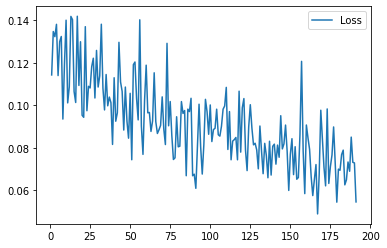

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the data

plt.plot(batch_number, cor_loss, label="Loss");

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
model.save_pretrained('./medbert')
from google.colab import files
files.download('./medbert')

In [ ]:
from transformers import pipeline
fill = pipeline('fill-mask', model='medbert', tokenizer='medbert')
fill(f' After how many hour from drinking an {fill.tokenizer.mask_token} can I drink alcohol? ')